# Query Operations

Objectives:
 * Learn how to use the query method for tabular datasets
 
Note: this notebook only works with HSDS!

In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Open a file containing stock quote data
f = h5pyd.File("/shared/sample/snp500.h5", 'r')

In [3]:
dset = f["dset"]
type(dset)  # The Table class is a one-dimensional dataset with compound type

h5pyd._hl.table.Table

In [4]:
# nrows is a table property - number of rows in the dataset
dset.nrows

3207353

In [5]:
# dtype is a list of field names and sub-types
dset.dtype

dtype([('date', 'S10'), ('symbol', 'S4'), ('sector', 'i1'), ('open', '<f4'), ('high', '<f4'), ('low', '<f4'), ('volume', '<f4'), ('close', '<f4')])

In [6]:
# The date field starting in 1970
arr = dset[:10]  # get first 10 elements
arr['date']  # date starts in 1970

array([b'1970.01.02', b'1970.01.02', b'1970.01.02', b'1970.01.02',
       b'1970.01.02', b'1970.01.02', b'1970.01.02', b'1970.01.02',
       b'1970.01.02', b'1970.01.02'], dtype='|S10')

In [7]:
arr = dset[-10:]  # get last 10 elements
arr['date']  # and ends in 2015

array([b'2015.11.20', b'2015.11.20', b'2015.11.20', b'2015.11.20',
       b'2015.11.20', b'2015.11.20', b'2015.11.20', b'2015.11.20',
       b'2015.11.20', b'2015.11.20'], dtype='|S10')

In [8]:
# If we wanted to extract all stock quotes with the symbol AAPL
# We could read the dataset in chunks and filter out anything 
# other than that symbol, but it would be rather slow
#
# More efficient is to use the dset query operator which can just 
# return rows matching the specification
symbol = "AAPL"
%time arr = dset.read_where(f"symbol == b'{symbol}'")

CPU times: user 112 ms, sys: 3.84 ms, total: 116 ms
Wall time: 1.12 s


In [9]:
arr.shape

(8813,)

In [9]:
# convert numpy result to Pandas dataframe
df = pd.DataFrame(arr)
df

,date,symbol,sector,open,high,low,volume,close
0,b'1980.12.12',b'AAPL',6,0.436339,0.438236,0.436339,117258400.0,0.436339
1,b'1980.12.15',b'AAPL',6,0.415471,0.415471,0.413574,43971200.0,0.413574
2,b'1980.12.16',b'AAPL',6,0.385117,0.385117,0.383220,26432000.0,0.383220
3,b'1980.12.17',b'AAPL',6,0.392705,0.394602,0.392705,21610400.0,0.392705
4,b'1980.12.18',b'AAPL',6,0.404088,0.405985,0.404088,18362400.0,0.404088
...,...,...,...,...,...,...,...,...
8808,b'2015.11.16',b'AAPL',6,111.379997,114.239998,111.000000,37651000.0,114.180000
8809,b'2015.11.17',b'AAPL',6,114.919998,115.050003,113.320000,27254000.0,113.690002
8810,b'2015.11.18',b'AAPL',6,115.760002,117.489998,115.500000,46163400.0,117.290001
8811,b'2015.11.19',b'AAPL',6,117.639999,119.750000,116.760002,42908200.0,118.779999


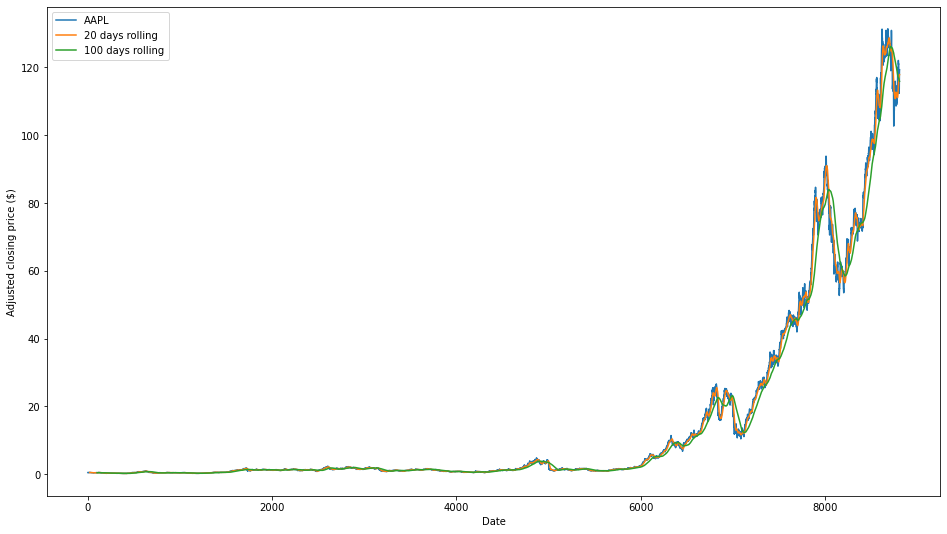

In [10]:
# Calculate the 20 and 100 days moving averages of the closing prices
close = df['close']
short_rolling = close.rolling(window=20).mean()
long_rolling = close.rolling(window=100).mean()

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(close.index, close, label=symbol)
ax.plot(short_rolling.index, short_rolling, label='20 days rolling')
ax.plot(long_rolling.index, long_rolling, label='100 days rolling')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()

In [11]:
df.describe()

,sector,open,high,low,volume,close
count,8813.0,8813.000000,8813.000000,8813.000000,8.813000e+03,8813.000000
mean,6.0,14.867317,15.023243,14.692136,9.230664e+07,14.860061
std,0.0,28.502213,28.753164,28.215895,8.859470e+07,28.486755
min,6.0,0.168844,0.168844,0.166947,2.504000e+05,0.166947
25%,6.0,0.909832,0.926958,0.888549,3.725680e+07,0.908528
50%,6.0,1.410330,1.435624,1.382501,6.468000e+07,1.410330
75%,6.0,11.656223,11.867720,11.434086,1.150212e+08,11.697458
max,6.0,132.729172,132.808136,130.250366,1.855410e+09,131.380386


In [13]:
%%time
# find the largest one day gain for any stock
# The create_cursor method let's you efficently access all the rows in the table
max_gain = 0.0
target = None
cursor = dset.create_cursor()
for row in cursor:
    gain = row["high"] - row["low"]
    if gain > max_gain:
        max_gain = gain
        target = np.copy(row)
print("largest gain:")
print(target)
    

largest gain:
(b'2000.04.04', b'LVLT', 8, 1483.125, 1486.875, 1065., 7208100., 1422.1875)
CPU times: user 5.11 s, sys: 44.1 ms, total: 5.15 s
Wall time: 28.4 s
